In [1]:
import camb
pars = camb.CAMBparams()
from scipy.special import jn, jn_zeros
from camb import model, initialpower
from scipy.interpolate import interp1d
from hankel_transform import *
from power_spectra import *
from astropy.cosmology import Planck15 as cosmo #use Planck15 if you can
import astropy.units as u
from matplotlib.colors import LogNorm
from scipy.signal import savgol_filter

rc('text', usetex=False)

In [2]:
DS_prof=np.genfromtxt('./BolPlanck_r_DS_50.txt',names=('rp','DS'))

In [3]:
dlogr=np.gradient(np.log10(DS_prof['rp']))[0]
rmin=0.01 #10**(np.log10(DS_prof['rp'][0])-dlogr/2)
rmax=20 #10**(np.log10(DS_prof['rp'][-1])+dlogr/2)
nbins=len(DS_prof['rp'])
rp_bins=np.logspace(np.log10(rmin),np.log10(rmax),nbins+1)

In [4]:
z_lens=np.atleast_1d([.3])#

In [5]:
#Set up a new set of parameters for power spectra and correlation functions
PS=Power_Spectra()
PS.pk_params['kmax']=520
PS.pk_params['kmin']=1e-2
PS.pk_params['non_linear']=1
rmin=.01
rmax=20

In [6]:
cosmo_params=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Odm0,'Om':cosmo.Om0,
                'As':2.14e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,
                  'w':-1,'wa':0})

In [7]:
pk,kh=PS.class_pk(z_lens,cosmo_params=cosmo_params,pk_params=pk_params,return_s8=False)
h=cosmo.h
k=kh*h
pk=pk/h**3
rho=PS.Rho_crit(cosmo=cosmo)*cosmo.Om0

In [8]:
#Setting up the Hankel Transform
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=PS.pk_params['kmax'],j_nu=[2],n_zeros=80000,kmin=PS.pk_params['kmin'],prune_r=2)
%time HT_inv=hankel_transform(rmin=PS.pk_params['kmin'],rmax=PS.pk_params['kmax'],kmax=rmax,j_nu=[2],n_zeros=80000,kmin=rmin,prune_r=50)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 81000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 82000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 83000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 84000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 85000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 86000
pruning r, log_space,n_f: True 2
pruned r: 774
nr: 773
CPU times: user 30.8 s, sys: 931 ms, total: 31.8 s
Wall time: 33.4 s
changed kmax to 513.5622301840683  to cover rmin
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 81000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 82000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 83000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 84000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 85000
j-nu= 2  not enough zeros to cover rmax, incre

In [9]:
x=HT_inv.k[2]>DS_prof['rp'].max()
DS2=DS_prof['DS'][-1]*DS_prof['rp'][-1]/HT_inv.k[2][x]
DS2=np.append(DS_prof['DS'],DS2)
rp2=np.append(DS_prof['rp'],HT_inv.k[2][x]) #this doesnot help
#DS2 = savgol_filter(DS2, 5, 3) # window size 51, polynomial order 3

/Users/Deep/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


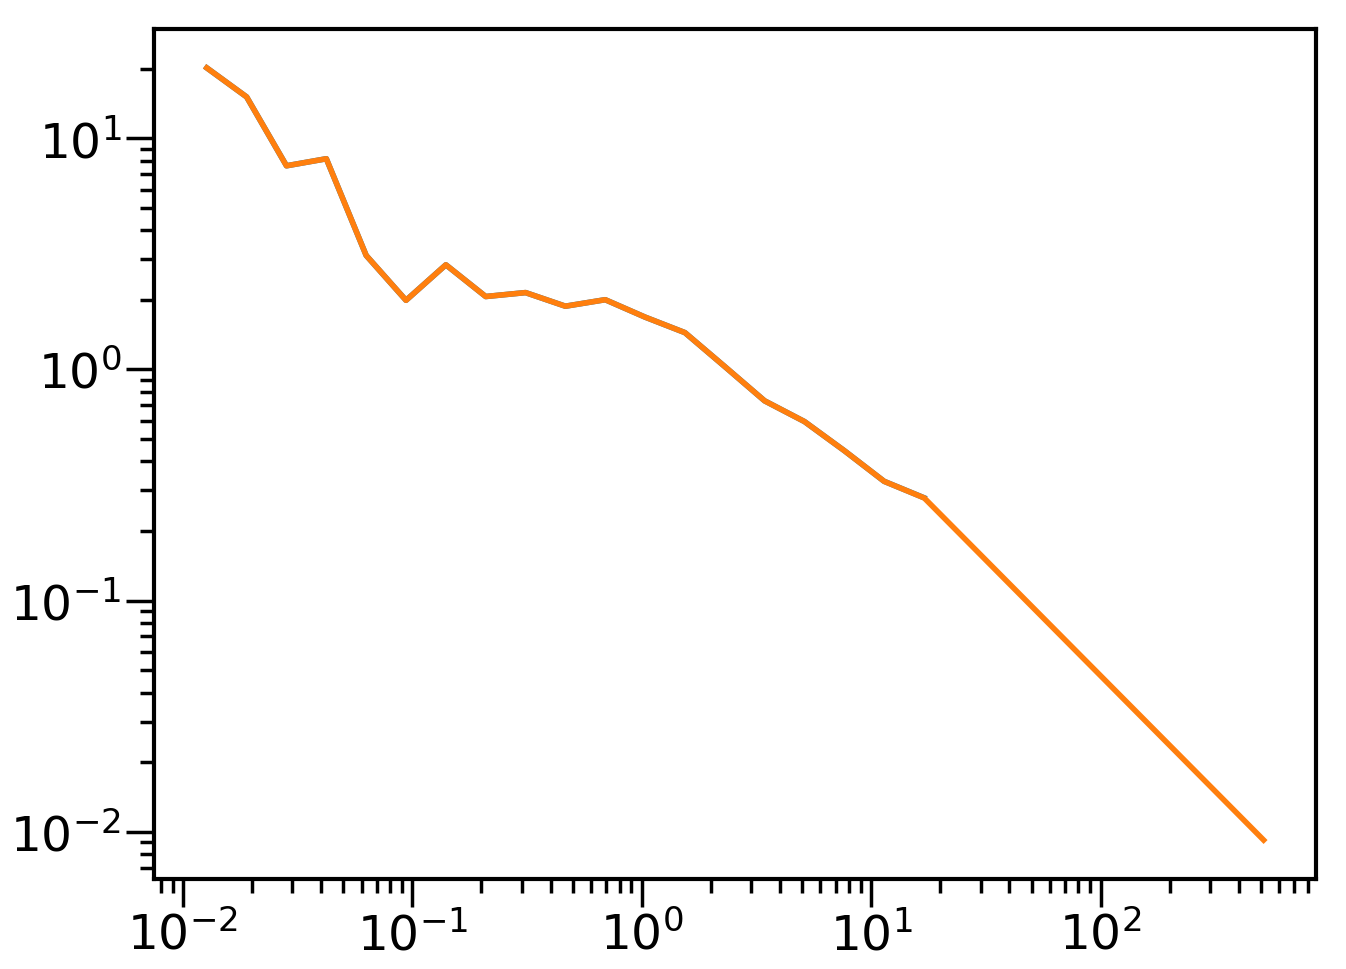

In [10]:
plot(DS_prof['rp'],DS_prof['DS'])
plot(rp2,DS2)
xscale('log')
yscale('log')

In [11]:
k2,p_gk2=HT_inv.projected_correlation(k_pk=rp2,pk=DS2,j_nu=2)
p_gk2*=(2*np.pi)**2 #factors due to fourier convention
p_gk2*=(HT.kmax**2/HT.rmax**2) #https://www.gnu.org/software/gsl/doc/html/dht.html
#p_gk2 = savgol_filter(p_gk2, 21, 3) # window size 51, polynomial order 3

In [12]:
b_g=1
p_g=b_g**2*pk[0]
p_gk=b_g*pk[0]*rho

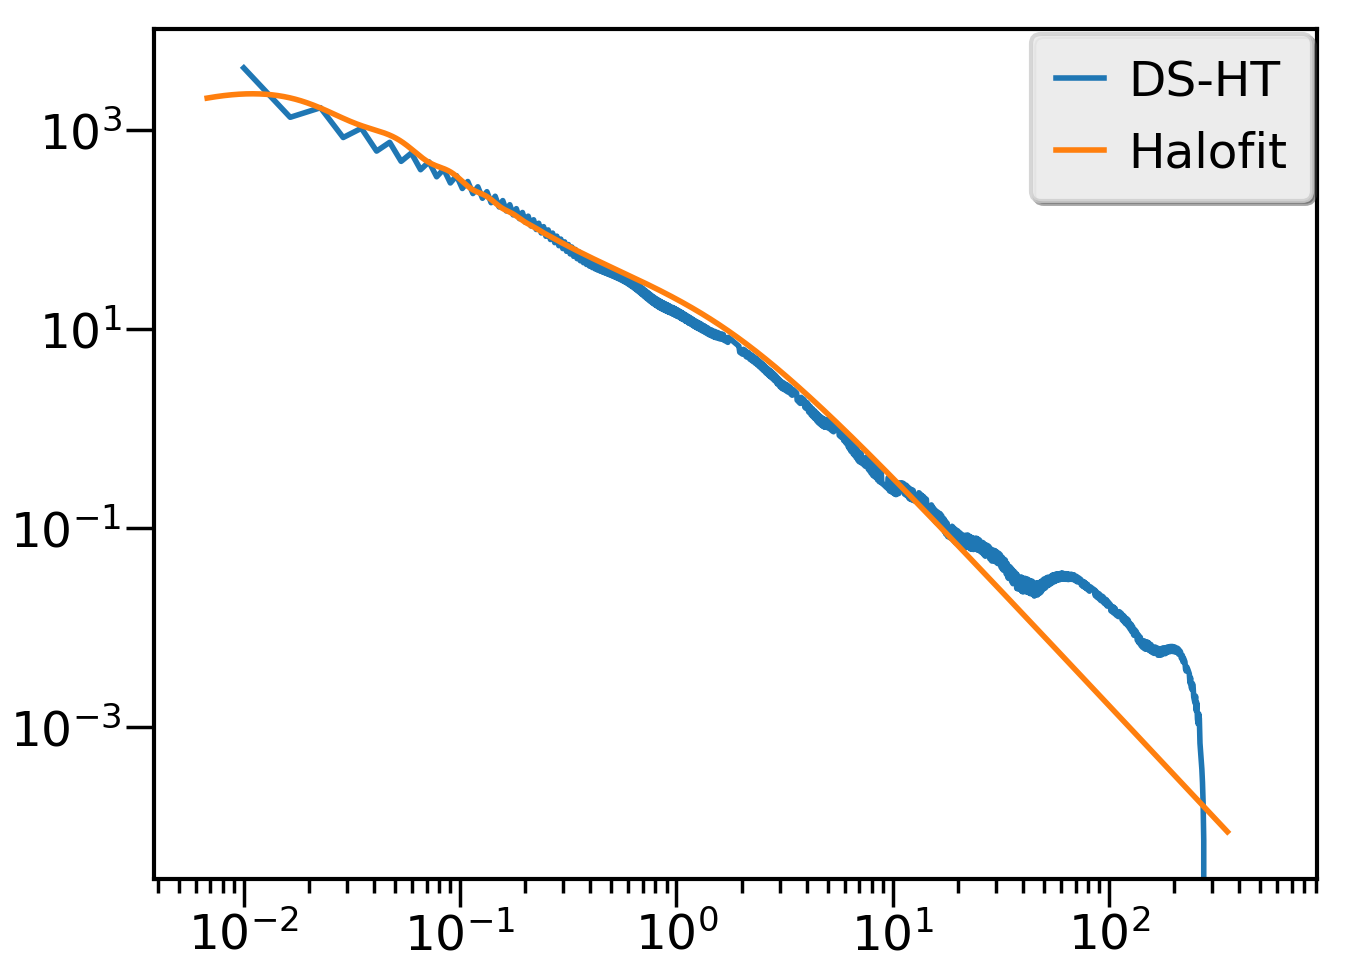

In [13]:
loglog(k2,p_gk2,label='DS-HT') #sim profile, extrapolated and then inv-HT
loglog(k,p_gk,label='Halofit')
legend()

In [14]:
r_th,DS_th2=HT.projected_correlation(k_pk=k2,pk=p_gk2,j_nu=2)
r_th,DS_th=HT.projected_correlation(k_pk=k,pk=p_gk,j_nu=2)

In [15]:
rp,DS_th_b=HT.bin_mat(r=r_th,r_bins=rp_bins,mat=DS_th) #bin the theory predictions
rp,DS_th_b2=HT.bin_mat(r=r_th,r_bins=rp_bins,mat=DS_th2) #bin the theory predictions

/Users/Deep/code/python_scripts/hankel_transform.py:200: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


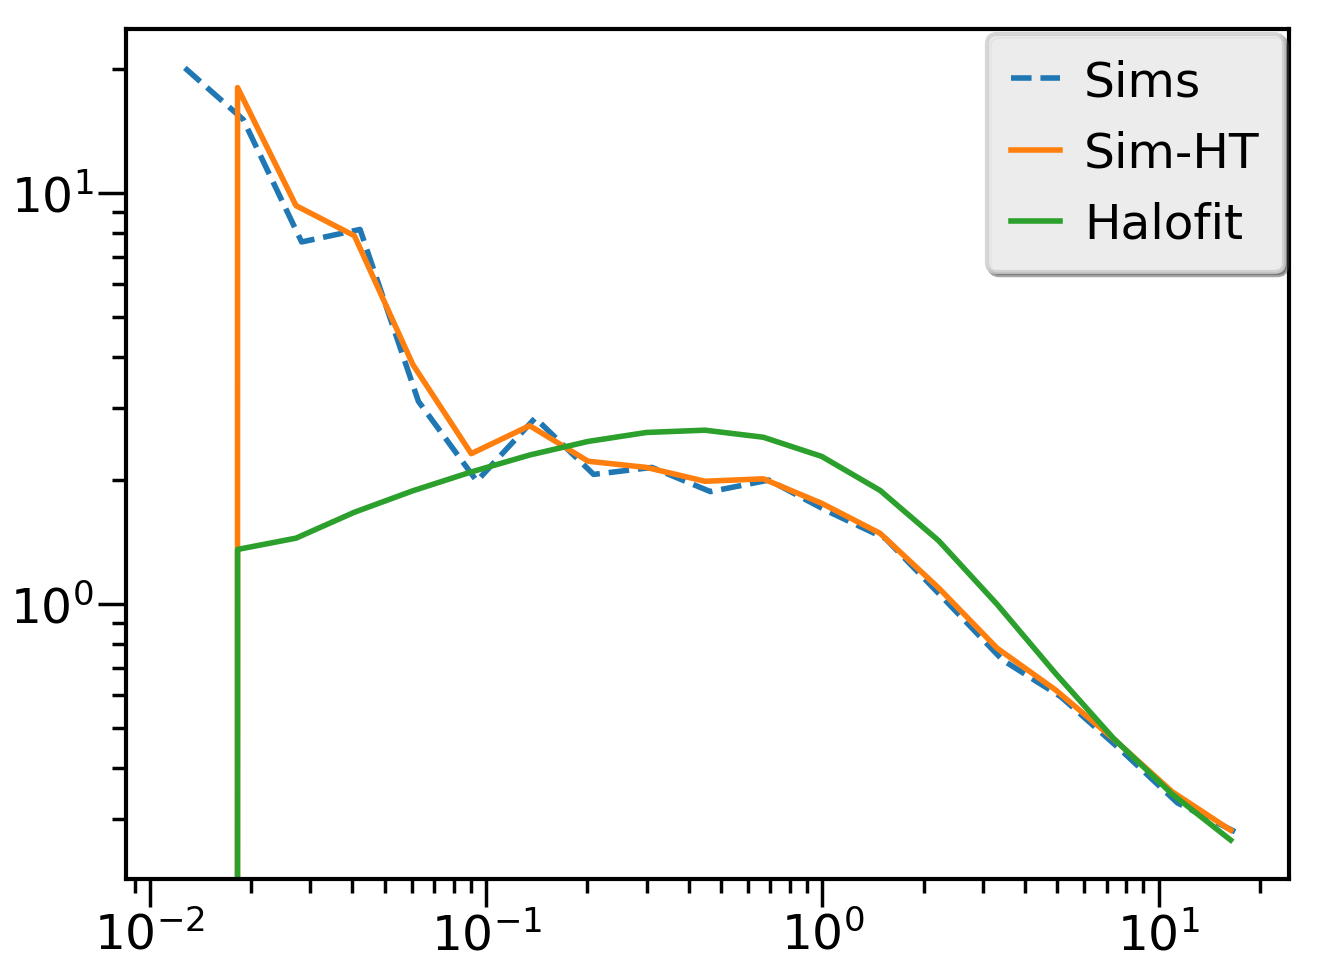

In [16]:
plot(DS_prof['rp'],DS_prof['DS'],'--',label='Sims')
plot(rp,DS_th_b2,label='Sim-HT') # Extrapolatred profile from sims, inv-HT to get power spectra and then HT back
plot(rp,DS_th_b,label='Halofit')
xscale('log')
yscale('log')
legend()

# g-g Lensing covariance

In [17]:
z_source=np.atleast_1d([1.2])
sigma_e=.36
sigma_gamma=sigma_e/sqrt(2)
n_s_arcmin=20 #perarcmin**2

In [18]:
n_g=3.e-4
g_shot_noise=1./n_g

In [19]:
z_lens_min=0.1
z_lens_max=0.6
L_W=cosmo.angular_diameter_distance(z_lens_max)-cosmo.angular_diameter_distance(z_lens_min)
L_W=L_W.value

area=10000 #in deg^-2
area_comoving=area*(np.pi/180)**2*cosmo.angular_diameter_distance(z=.27)**2

In [20]:
sigma_crit=PS.sigma_crit(zl=z_lens,zs=z_source,cosmo=cosmo)
sigma_crit=sigma_crit[0,0].value

In [21]:
d2r=np.pi/180.
n_s=n_s_arcmin*3600/d2r**2
shape_noise=sigma_gamma**2/n_s

In [22]:
l,cl_kappa_kappa=PS.kappa_cl(zs1=z_source,p_zs1=[1],zs2=z_source,p_zs2=[1],zl_max=z_source,n_zl=100,
                             l=np.arange(5.e5),cosmo=cosmo)
chi=cosmo.angular_diameter_distance(z_lens)
k_l=(l+0.5)/chi
cl_intp=interp1d(k_l,cl_kappa_kappa,bounds_error=False,fill_value=0)
p_kappa_kappa=sigma_crit**2*(cl_intp(k)+shape_noise)*chi**2

power_spectra.py:231: RuntimeWarning: divide by zero encountered in divide
  pk_int=interp1d(lz,pk[i]/DC_i**2,bounds_error=False,fill_value=0)
/Users/Deep/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)
power_spectra.py:257: RuntimeWarning: divide by zero encountered in divide
  f=(l+0.5)**2/(l*(l+1.)) #correction from Kilbinger+ 2017


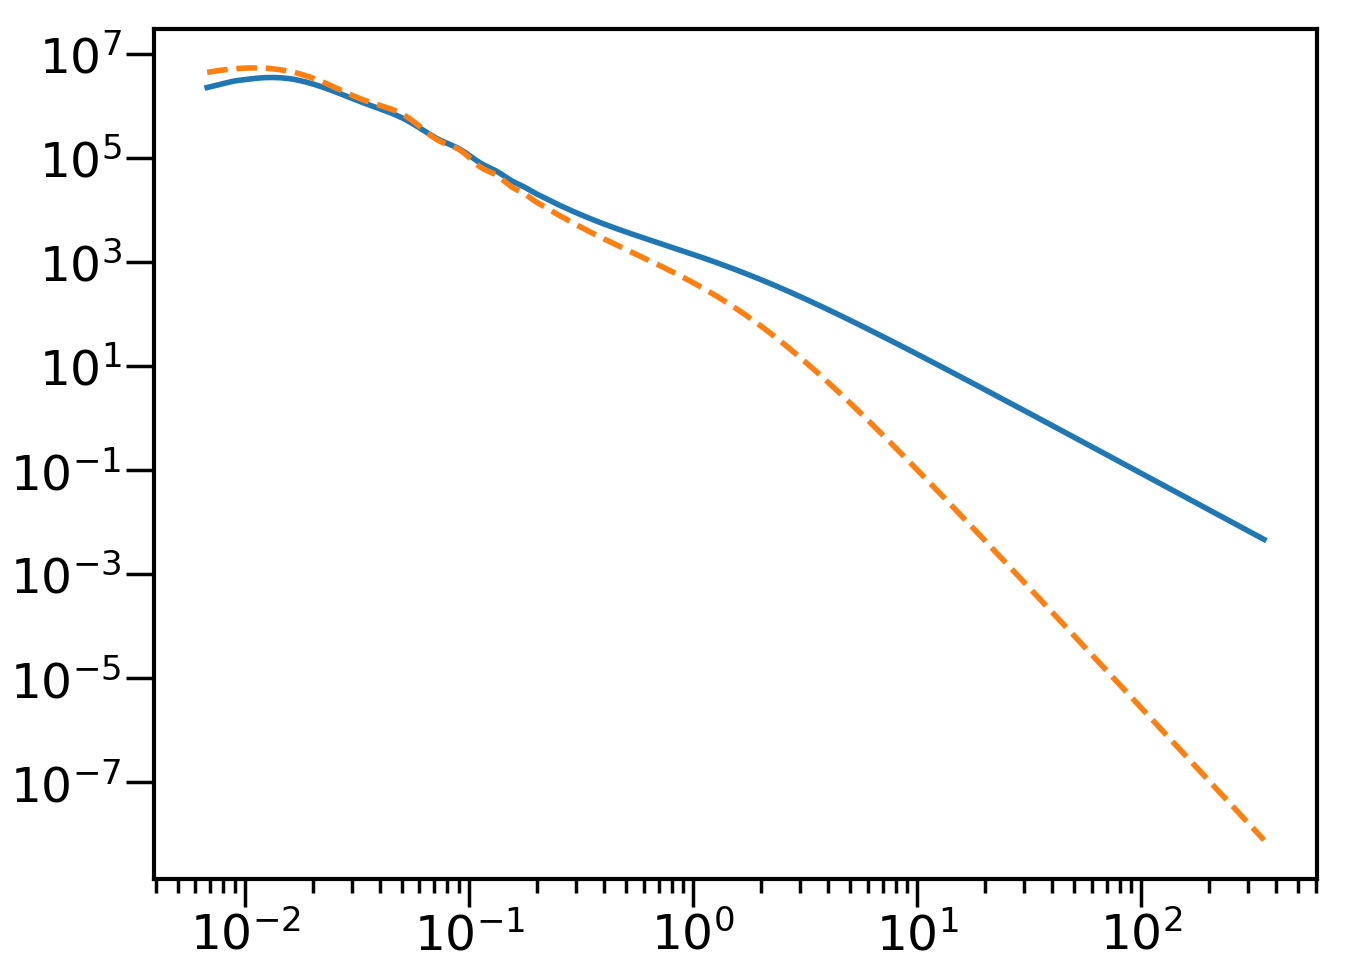

In [23]:
plot(k,p_kappa_kappa*p_g/L_W)
plot(k,p_gk**2,'--')
xscale('log')
yscale('log')

In [24]:
taper_kw=dict({'large_k_lower':500,'large_k_upper':PS.pk_params['kmax'],'low_k_lower':PS.pk_params['kmin'],
               'low_k_upper':PS.pk_params['kmin']*1.2})

In [25]:
r,cov_ggkk=HT.projected_covariance(k_pk=k,pk1=p_g+g_shot_noise,pk2=p_kappa_kappa,j_nu=2,taper=True,**taper_kw)
r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=rp_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

/Users/Deep/code/python_scripts/hankel_transform.py:130: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [26]:
r,cov_gkgk=HT.projected_covariance(k_pk=k,pk1=p_gk,pk2=p_gk,j_nu=2,taper=True,**taper_kw)#return_Jrr=True,Jrr=Jrr
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=rp_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

In [27]:
cov_ggkk_re/=(area_comoving.value*L_W)
cov_gkgk_re/=area_comoving.value
cov_final=(cov_ggkk_re+cov_gkgk_re)#/area_comoving.value
corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)
errors_ggkk=HT.diagonal_err(cov=cov_ggkk_re)
errors_gkgk=HT.diagonal_err(cov=cov_gkgk_re)

(0.01, 20)

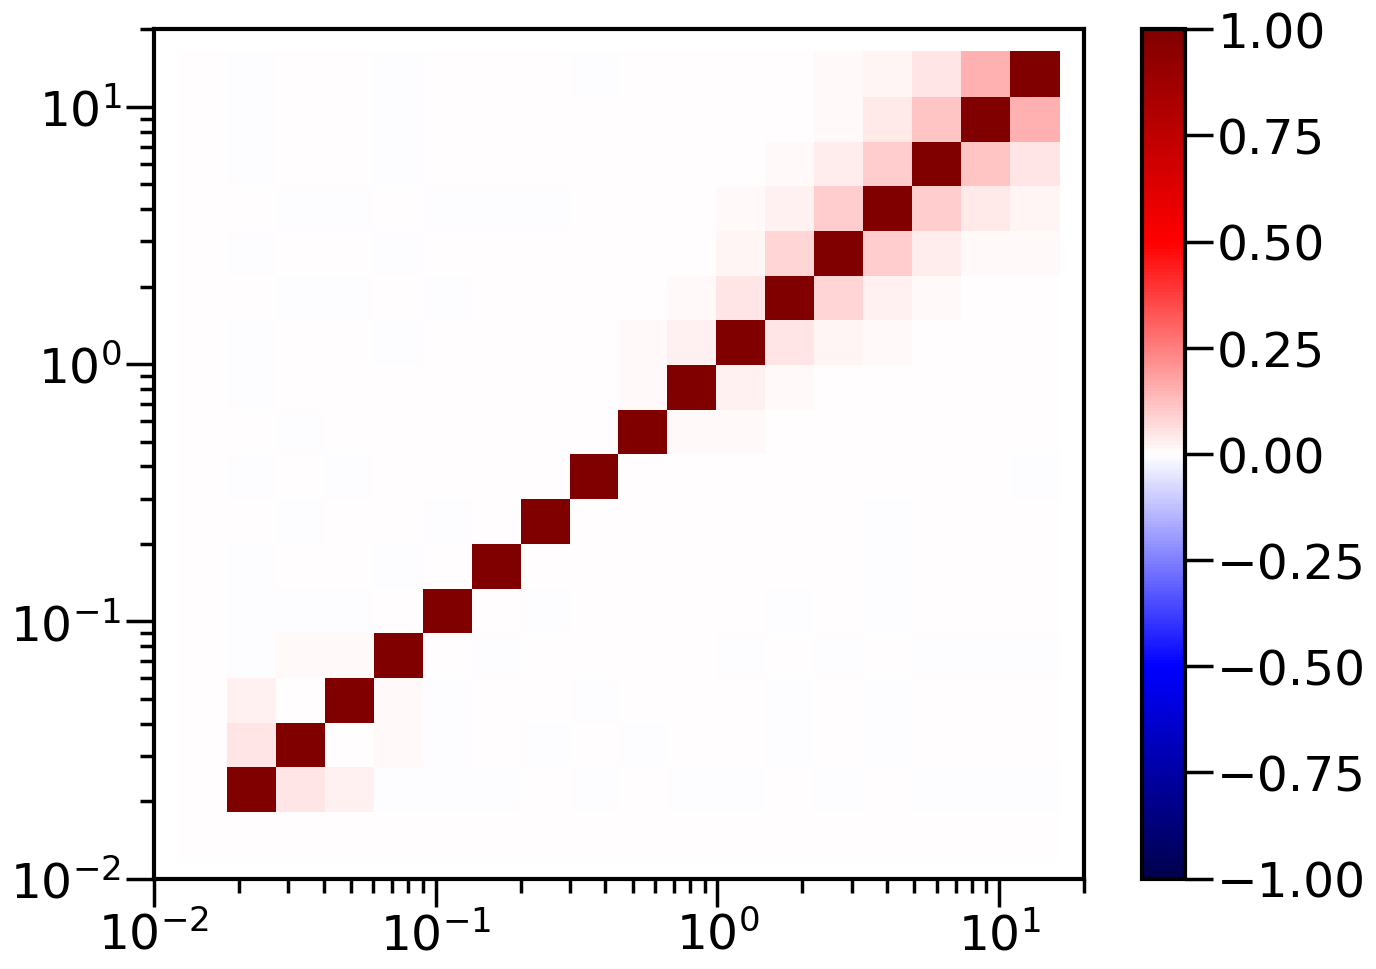

In [28]:
pcolor(r_re,r_re,corr,vmin=-1,vmax=1,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(HT.rmin,HT.rmax)
ylim(HT.rmin,HT.rmax)

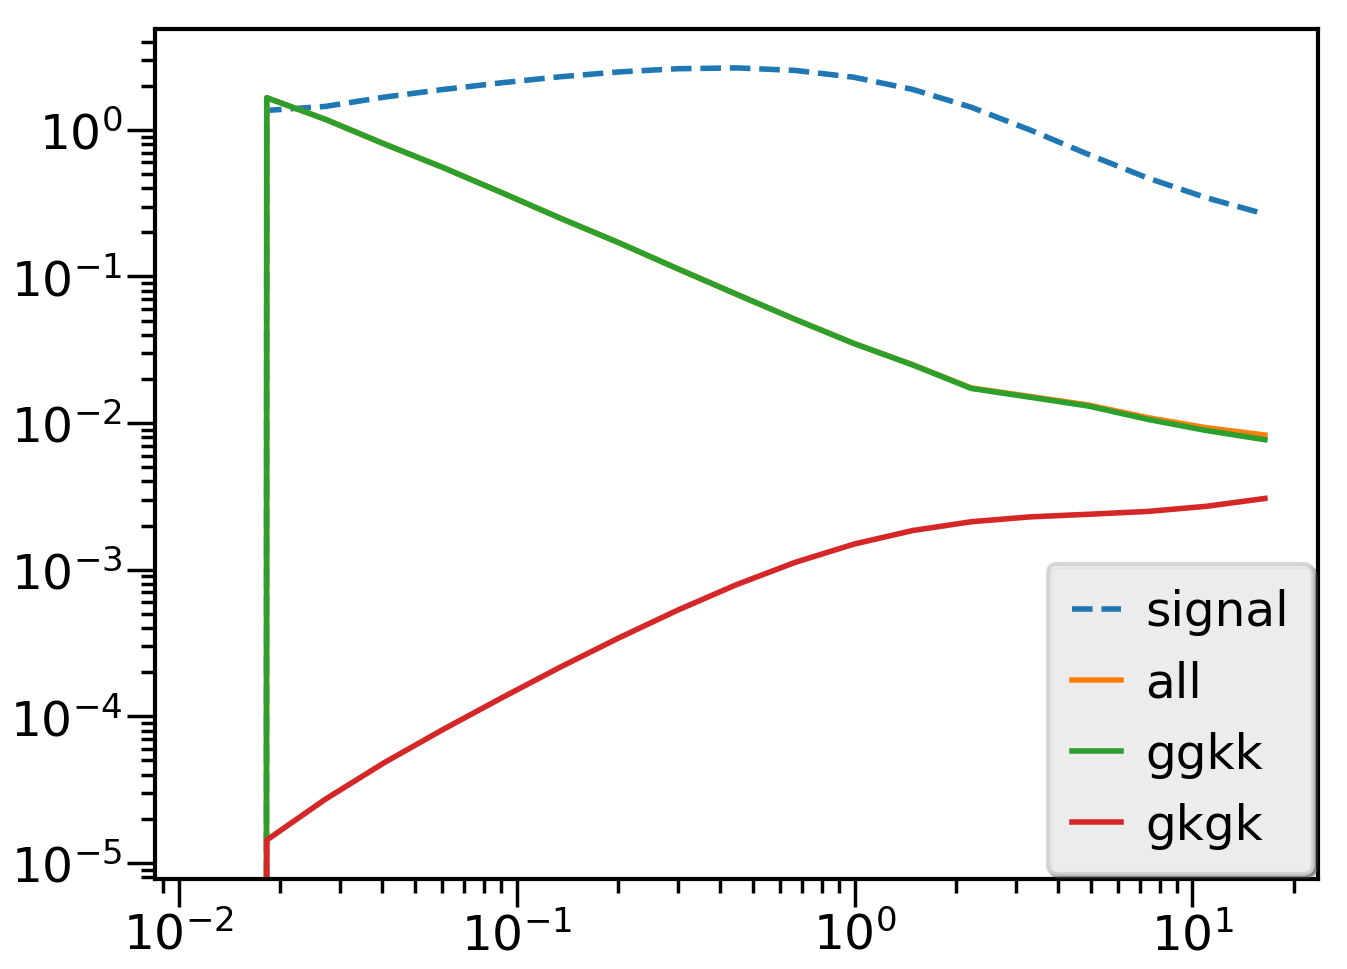

In [29]:
plot(rp,DS_th_b,'--',label='signal')
plot(r_re,errors,label='all')
plot(r_re,errors_ggkk,label='ggkk')
plot(r_re,errors_gkgk,label='gkgk')
xscale('log')
yscale('log')
legend()
# xlim(1,100)